## 1. Importation des bibliothèques :

- **NumPy** : Manipulation des données  
- **Matplotlib** : Affichage des signaux  
- **SoundDevice** : Gestion de l’audio  
- **Wavio** : Sauvegarde WAV  
- **SciPy Signal** : Filtres & analyse spectrale  
- **Tkinter** : Sélection de fichiers  

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import wavio
import scipy.signal as signal
from scipy.signal import cheby1, filtfilt, welch
from tkinter import Tk, filedialog

## 2. Sélection ou Enregistrement de l'audio :

Fonction `choisir_fichier()`
- Utilise **Tkinter** pour ouvrir une boîte de dialogue.
- Permet à l'utilisateur de sélectionner un fichier `.wav`.
- Cache la fenêtre Tkinter avec `withdraw()

Fonction `enregistrer_son()`
- Enregistre **un son** depuis le micro avec **SoundDevice**.
- Durée et fréquence d'échantillonnage réglables (`duree`, `frequence`).
- Sauvegarde l’audio en **WAV** avec **Wavio**.


In [92]:
def choisir_fichier():
    """Ouvre une boîte de dialogue pour sélectionner un fichier audio .wav."""
    root = Tk()
    root.withdraw()  # Cacher la fenêtre Tkinter
    fichier_audio = filedialog.askopenfilename(filetypes=[("Fichiers WAV", "*.wav")])
    return fichier_audio

def enregistrer_son(duree=5, frequence=44100):
    """Enregistre un son via le micro et l'enregistre en fichier .wav."""
    print(f"🎤 Enregistrement pendant {duree} secondes...")
    audio = sd.rec(int(duree * frequence), samplerate=frequence, channels=1, dtype='float32')
    sd.wait()  
    fichier_audio = "enregistrement.wav"
    wavio.write(fichier_audio, audio, frequence, sampwidth=2)
    print(f"✅ Enregistrement terminé : {fichier_audio}")
    return fichier_audio

## 3. Le choix de l'utilisateur :

Le programme demande à l'utilisateur d'importer un fichier ou d'enregistrer un son, puis exécute l'action choisie. Si l'entrée est invalide, un message d'erreur s'affiche. Enfin, le fichier sélectionné ou enregistré est affiché.

In [93]:
# Demander à l'utilisateur s'il veut importer un fichier ou enregistrer un son
choix = input("Voulez-vous importer un fichier (1) ou enregistrer un nouveau son (2) ? ")

if choix == "1":
    fichier = choisir_fichier()
elif choix == "2":
    fichier = enregistrer_son()
else:
    print("❌ Choix invalide !")
    fichier = None

# Vérifier que l'utilisateur a bien sélectionné un fichier
if fichier:
    print(f"📂 Fichier sélectionné : {fichier}")

🎤 Enregistrement pendant 5 secondes...
✅ Enregistrement terminé : enregistrement.wav
📂 Fichier sélectionné : enregistrement.wav


## 4. Chargement du signal audio :

La lecture du fichier audio se fait avec Scipy, qui extrait la fréquence d’échantillonnage et les données audio. Si le fichier est en stéréo (deux canaux), un seul canal est conservé pour obtenir un signal mono. Ensuite, le signal est normalisé entre -1 et 1 pour éviter toute distorsion. Enfin, Matplotlib affiche le signal en fonction du temps.

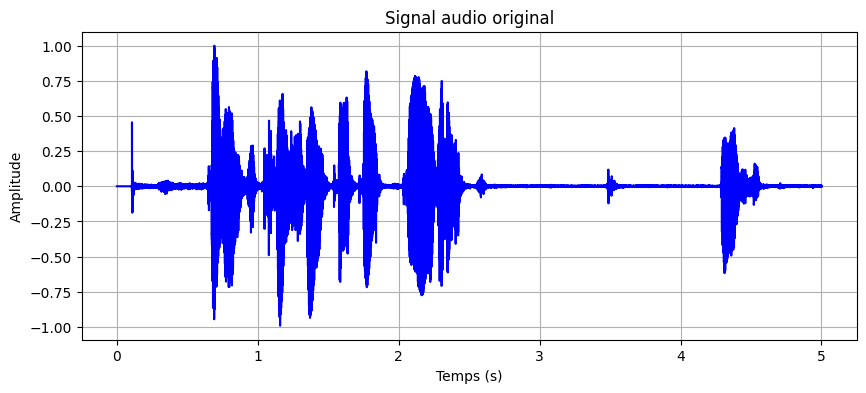

In [94]:
from scipy.io import wavfile

# Charger le fichier audio
frequence, audio = wavfile.read(fichier)

# Convertir en mono si stéréo
if len(audio.shape) > 1:
    audio = audio[:, 0]

# Normaliser le signal entre -1 et 1
audio = audio / np.max(np.abs(audio))

# Affichage du signal
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(audio) / frequence, len(audio)), audio, color='blue')
plt.title("Signal audio original")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

L'estimation de la densité spectrale de puissance (DSP) est réalisée avec la méthode de Welch, qui segmente le signal en blocs de 1024 échantillons. 

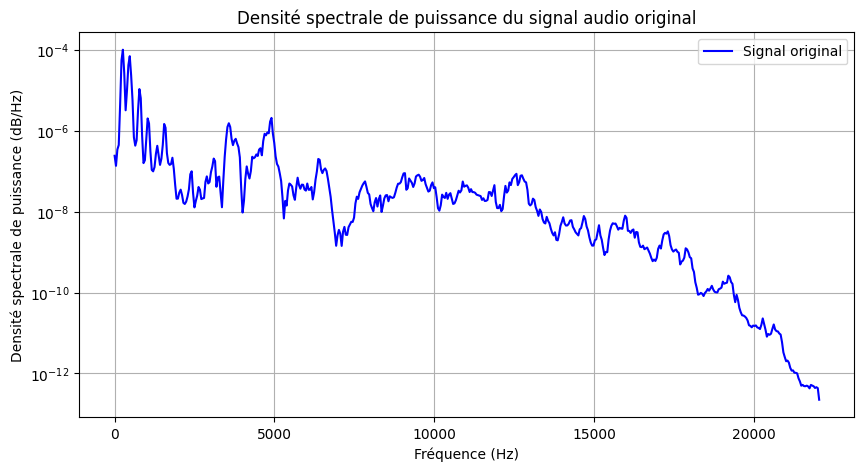

In [102]:
frequences_orig, dsp_orig = welch(audio, fs=frequence, nperseg=1024) #1024 échantillons

# Affichage de la DSP
plt.figure(figsize=(10, 5))
plt.semilogy(frequences_orig, dsp_orig, label="Signal original", color="blue")

plt.title("Densité spectrale de puissance du signal audio original")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité spectrale de puissance (dB/Hz)")
plt.legend()
plt.grid()
plt.show()

## 5. Génération d'un bruit blanc :

La génération de bruit blanc est réalisée en ajoutant un signal aléatoire de moyenne 0 et d'écart type 0.05 à la forme du signal audio. L'enregistrement du bruit est effectué dans un fichier .wav, avec une conversion en entiers 16 bits pour correspondre au format audio standard.

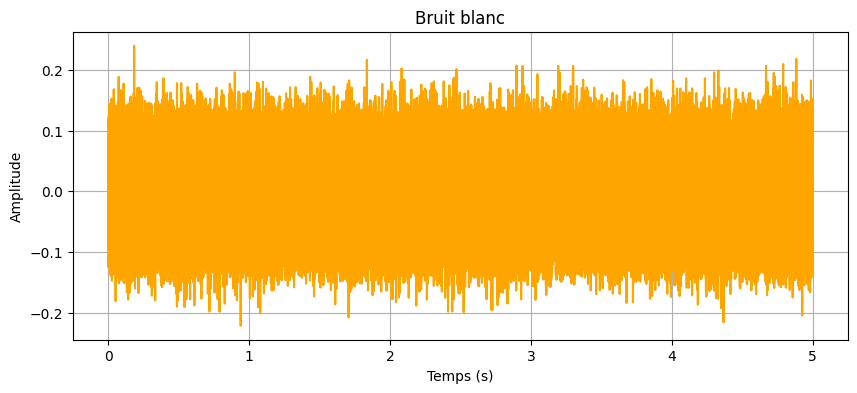

In [96]:
# Ajouter du bruit blanc
bruit = np.random.normal(0, 0.05, audio.shape)
wavfile.write("bruit.wav", frequence, (bruit * 32767).astype(np.int16))

plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(audio) / frequence, len(audio)), bruit, color='orange')
plt.title("Bruit blanc")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

Le calcul de la densité spectrale de puissance (DSP) du bruit blanc est effectué avec la méthode de Welch, en segmentant le signal en blocs de 1024 échantillons.

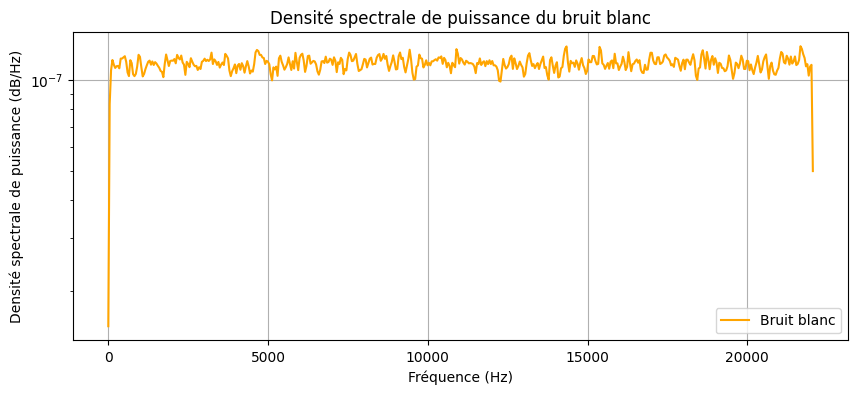

In [97]:
# Calcul de la DSP avec la méthode de Welch
freqs, psd = welch(bruit, frequence, nperseg=1024)

# Affichage de la DSP
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, psd, color='orange', label="Bruit blanc")
plt.title("Densité spectrale de puissance du bruit blanc")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité spectrale de puissance (dB/Hz)")
plt.grid()
plt.legend()
plt.show()

## 6. Ajout du bruit blanc au signal :

L'ajout du bruit blanc au signal audio est effectué en additionnant les deux signaux. Le signal résultant est converti en int16 et enregistré sous le nom "audio_bruit.wav".

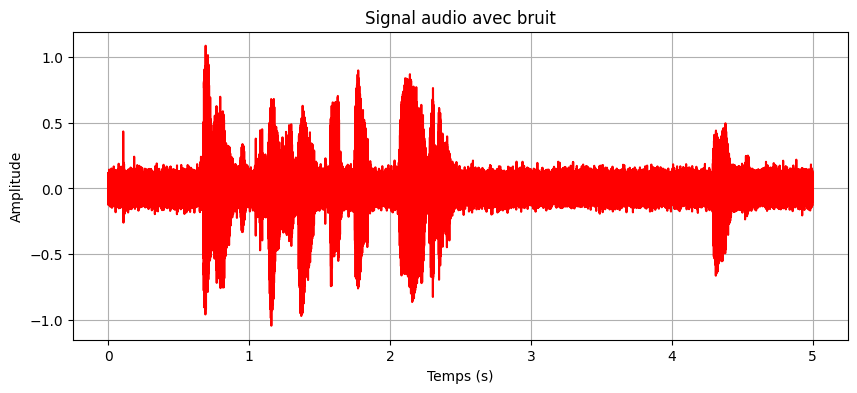

In [98]:
audio_bruit = audio + bruit
wavfile.write("audio_bruit.wav", frequence, (audio_bruit * 32767).astype(np.int16))


# Affichage du signal bruité
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(audio) / frequence, len(audio)), audio_bruit, color='red')
plt.title("Signal audio avec bruit")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

La densité spectrale de puissance (DSP) du signal bruité est calculée avec la méthode de Welch, en segmentant le signal en blocs de 1024 échantillons.

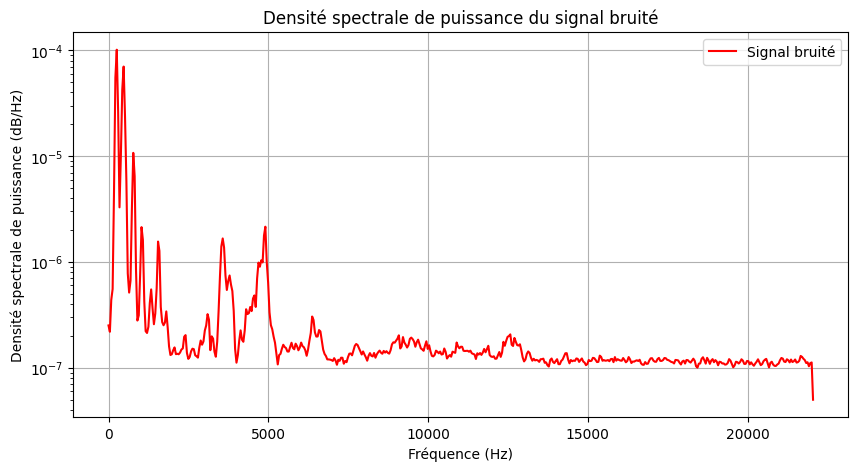

In [99]:
frequences_bruit, dsp_bruit = welch(audio_bruit, fs=frequence, nperseg=1024)

# Affichage de la DSP
plt.figure(figsize=(10, 5))
plt.semilogy(frequences_bruit, dsp_bruit, label="Signal bruité", color="red")

plt.title("Densité spectrale de puissance du signal bruité")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité spectrale de puissance (dB/Hz)")
plt.legend()
plt.grid()
plt.show()

## 7. Filtrage avec Tchebychev :

Caractéristiques du filtre
Un filtre passe-bas de Tchebychev de type I est utilisé pour atténuer les hautes fréquences tout en conservant une ondulation contrôlée dans la bande passante.

- **Ordre** : 6 (définit la complexité du filtre)
- **Fréquence de coupure** : 4000 Hz (limite supérieure des fréquences conservées)
- **Ondulation** : 0,5 dB (variation tolérée dans la bande passante)

Traitement du signal audio
1. **Lecture du fichier audio bruité** : Le signal contenant du bruit blanc est chargé.
2. **Normalisation** : Le signal est mis à l’échelle entre -1 et 1 pour assurer un traitement optimal.
3. **Conception du filtre** : Les coefficients du filtre Tchebychev sont calculés.
4. **Application du filtre** : Le signal bruité est filtré pour supprimer les hautes fréquences.
5. **Sauvegarde du signal filtré** : Le résultat est enregistré sous forme de fichier .wav.
6. **Affichage du signal filtré** : La forme d’onde du signal après filtrage est visualisée pour observer l'atténuation du bruit.

Ce processus permet de restaurer la qualité du signal audio en éliminant les composantes haute fréquence indésirables.

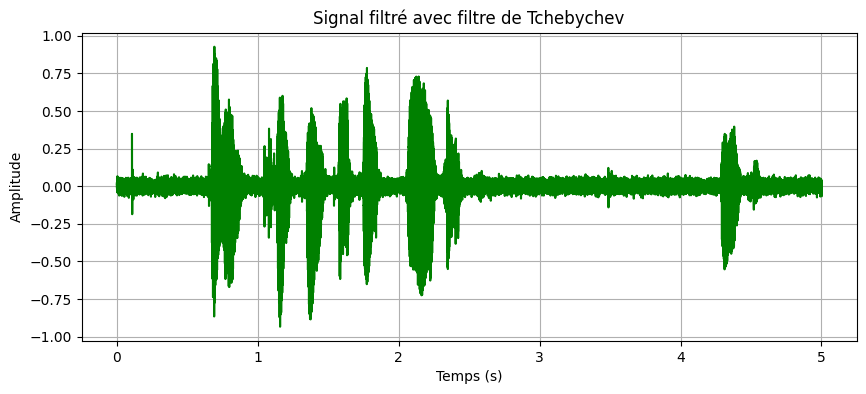

In [100]:
# Paramètres du filtre Tchebychev
frequence_coupure = 4000  # Hz
ordre = 6
ripple = 0.5  # Ondulation dans la bande passante (dB)

# Conception du filtre passe-bas de Tchebychev de type I
b, a = signal.cheby1(ordre, ripple, frequence_coupure / (frequence / 2), btype='low')

# Application du filtre sur le signal bruité
audio_filtre2 = signal.filtfilt(b, a, audio_bruit)
wavfile.write("audio_filtre.wav", frequence, (audio_filtre2 * 32767).astype(np.int16))


# Affichage du signal filtré
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(audio) / frequence, len(audio)), audio_filtre2, color='green')
plt.title("Signal filtré avec filtre de Tchebychev")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

La densité spectrale de puissance (DSP) du signal filtré est calculée avec la méthode de Welch, en segmentant le signal en blocs de 1024 échantillons.

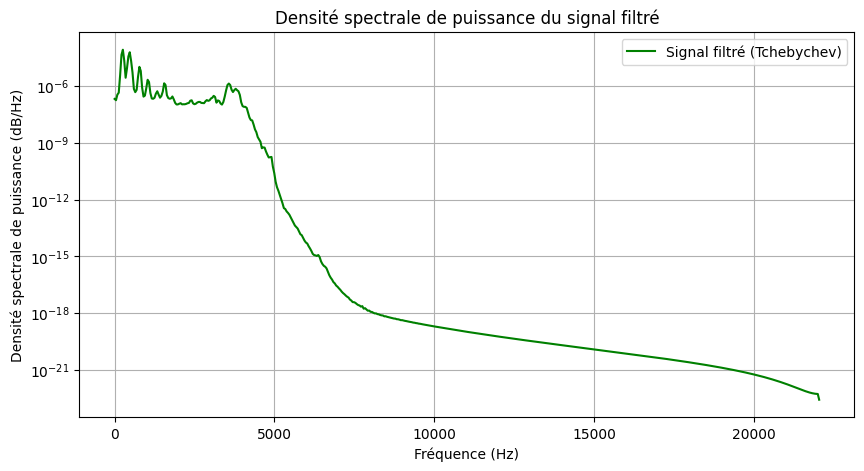

In [101]:
# Calcul de la DSP
frequencies, psd = signal.welch(audio_filtre2, fs=frequence, nperseg=1024)

# Affichage de la DSP
plt.figure(figsize=(10, 5))
plt.semilogy(frequencies, psd, color='green', label="Signal filtré (Tchebychev)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité spectrale de puissance (dB/Hz)")
plt.title("Densité spectrale de puissance du signal filtré")
plt.legend()
plt.grid()
plt.show()